# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

# Ignore the Warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load The DataSet

In [3]:
data = pd.read_csv('spam.csv', encoding = "latin-1")

In [4]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# Removing UnWanted Columns

In [5]:
data = data[["v1","v2"]]

# Renaming The Columns

In [6]:
data.rename(columns={"v1":"label","v2":"text"},inplace=True)

In [7]:
data

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
data.duplicated().sum()

403

###### Data Contains Duplicates Rows Hence We Need To Remove Them

In [11]:
data.drop_duplicates(inplace = True)

In [12]:
data.label.value_counts()

ham     4516
spam     653
Name: label, dtype: int64

# Data Visualization

<Axes: ylabel='label'>

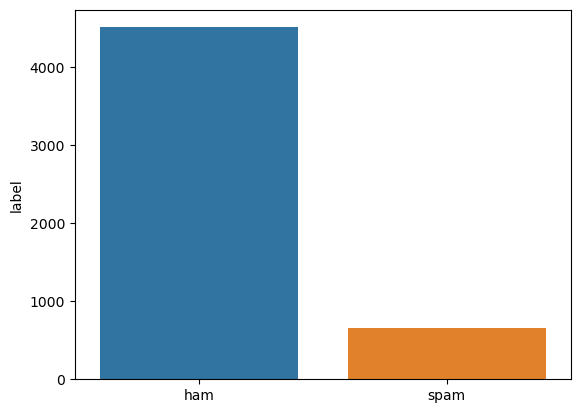

In [13]:
sns.barplot(x = data.label.value_counts().index, y = data.label.value_counts())

<Axes: xlabel='text', ylabel='Count'>

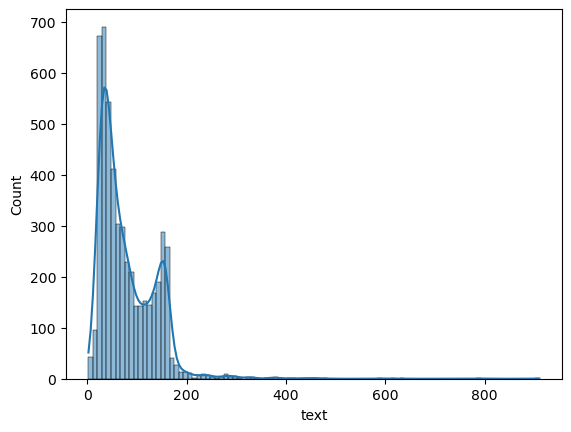

In [14]:
sns.histplot(data["text"].apply(len), bins = 100, kde = True)

<Axes: title={'center': 'Average Number of Sentences'}, xlabel='type', ylabel='sentences'>

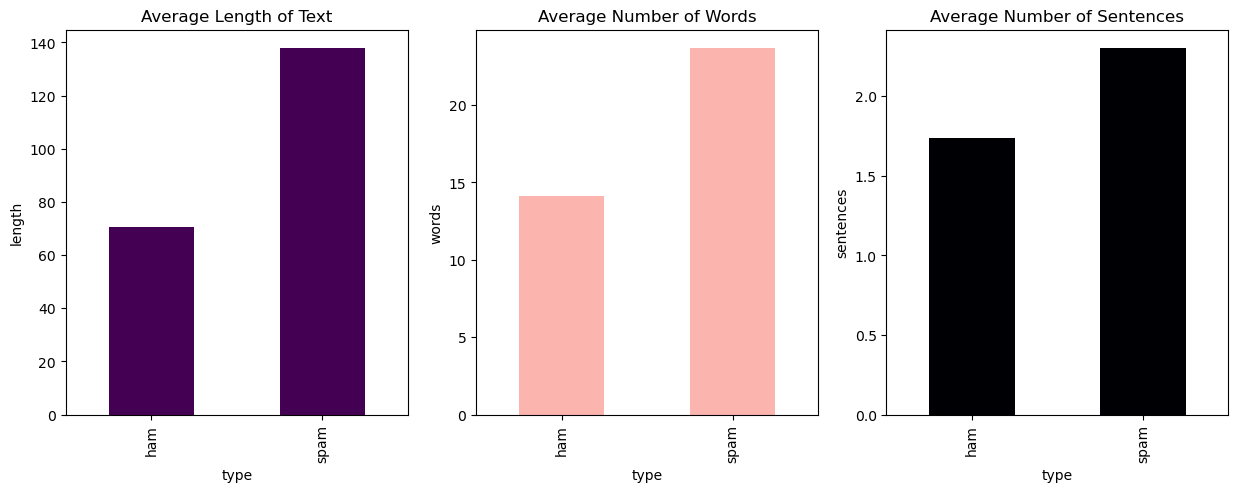

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

data.groupby("label").apply(lambda x: x["text"].apply(len).mean()).plot(
    kind = "bar", ax = ax1, title = "Average Length of Text", xlabel = "type", ylabel = "length", colormap = "viridis")

data.groupby("label").apply(lambda x: x["text"].apply(lambda x: len(x.split())).mean()).plot(
    kind = "bar", ax = ax2, title = "Average Number of Words", xlabel = "type", ylabel = "words", colormap = "Pastel1")

data.groupby("label").apply(lambda x: x["text"].apply(lambda x: len(x.split(". "))).mean()).plot(
    kind = "bar", ax = ax3, title = "Average Number of Sentences", xlabel = "type", ylabel = "sentences", colormap = "magma")

In [16]:
!pip install wordcloud

(-0.5, 799.5, 511.5, -0.5)

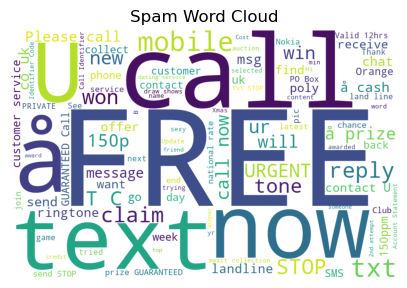

In [17]:
spam_words = ' '.join(list(data[data['label'] == 'spam']['text']))
spam_wc = WordCloud(width = 800, height = 512, max_words = 100, background_color = "white").generate(spam_words)

plt.figure(figsize = (5, 6))
plt.title('Spam Word Cloud')
plt.imshow(spam_wc)
plt.axis('off')

(-0.5, 799.5, 511.5, -0.5)

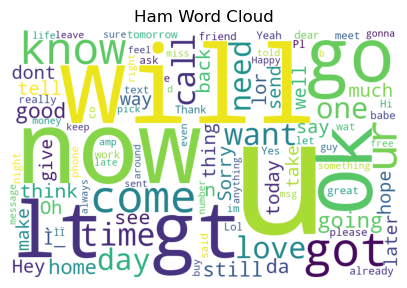

In [18]:
ham_words = ' '.join(list(data[data['label'] == 'ham']['text']))
ham_wc = WordCloud(width = 800, height = 512, max_words = 100, background_color = "white").generate(ham_words)

plt.figure(figsize = (5, 6))
plt.title('Ham Word Cloud')
plt.imshow(ham_wc)
plt.axis('off')

# Data Preprocessing

In [19]:
data["text"].sample(5)

5235    Am on the uworld site. Am i buying the qbank o...
382            Hey leave it. not a big deal:-) take care.
24      Ffffffffff. Alright no way I can meet up with ...
4722                     HELLO PEACH! MY CAKE TASTS LUSH!
1199    NEFT Transaction with reference number  &lt;#&...
Name: text, dtype: object

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Microsoft\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = stopwords.words('english')

In [22]:
def clean_text(text):

    text= text.lower() 
    text = re.sub('-',' ',text.lower())   
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(f'[{string.punctuation}]', '', text) 
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    words = nltk.tokenize.word_tokenize(text,language = "english", preserve_line = True)
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2]) # Removing the stop words

    return text.strip()

In [23]:
data["clean_text"] = data["text"].apply(clean_text)

In [24]:
data

,label,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts 21st m...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried contact å£750 pound prize claim...
5568,ham,Will Ì_ b going to esplanade fr home?,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


# Split The Data Into Training and Testing Sets

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(data["clean_text"], data["label"], test_size = 0.2, random_state = 42)

# Vectorizing

In [26]:
vectorizer = CountVectorizer(stop_words = 'english', lowercase = True)

In [27]:
X_train_vectorized = vectorizer.fit_transform(X_train)

In [28]:
X_test_vectorized = vectorizer.transform(X_test)

# Label Encoder

In [29]:
Label_Encoder = LabelEncoder()

In [30]:
Y_train = Label_Encoder.fit_transform(Y_train)

In [31]:
Y_test = Label_Encoder.transform(Y_test)

# Random Over Sampler

In [32]:
sampler = RandomOverSampler(random_state = 42)

In [33]:
X_train_resampled, Y_train_resampled = sampler.fit_resample(X_train_vectorized, Y_train)

# Modelling

## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
LogisticRegressionModel = LogisticRegression(C = 1000, solver = "sag", tol = 0.001, max_iter = 500, random_state = 15)

## Fit The Training Data

In [36]:
LogisticRegressionModel.fit(X_train_resampled, Y_train_resampled)

LogisticRegression(C=1000, max_iter=500, random_state=15, solver='sag',
                   tol=0.001)

## Accuracy & Precision of Training and Testing Data

In [37]:
print("Train Accuracy: ", LogisticRegressionModel.score(X_train_resampled, Y_train_resampled) * 100)
print("Test Accuracy: ", LogisticRegressionModel.score(X_test_vectorized, Y_test) * 100)
print("Train Precision: ", precision_score(Y_train_resampled, LogisticRegressionModel.predict(X_train_resampled)) * 100)
print("Test Precision: ", precision_score(Y_test, LogisticRegressionModel.predict(X_test_vectorized)) * 100)

Train Accuracy:  100.0
Test Accuracy:  97.96905222437138
Train Precision:  100.0
Test Precision:  97.6923076923077


## Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB

In [39]:
NaiveBayesModel = MultinomialNB(alpha = 0.1)

## Fit The Training Data

In [40]:
NaiveBayesModel.fit(X_train_resampled, Y_train_resampled)

MultinomialNB(alpha=0.1)

## Accuracy & Precision of Training and Testing Data

In [41]:
print("Train Accuracy: ", NaiveBayesModel.score(X_train_resampled, Y_train_resampled) * 100)
print("Test Accuracy: ", NaiveBayesModel.score(X_test_vectorized, Y_test) * 100)
print("Train Precision: ", precision_score(Y_train_resampled, NaiveBayesModel.predict(X_train_resampled)) * 100)
print("Test Precision: ", precision_score(Y_test, NaiveBayesModel.predict(X_test_vectorized)) * 100)

Train Accuracy:  98.9660876757651
Test Accuracy:  96.42166344294004
Train Precision:  98.60426929392446
Test Precision:  84.61538461538461


## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
RandomForestModel = RandomForestClassifier(random_state = 42)

## Fit The Training Data

In [44]:
RandomForestModel.fit(X_train_resampled, Y_train_resampled)

RandomForestClassifier(random_state=42)

## Accuracy & Precision of Training and Testing Data

In [45]:
print("Train Accuracy: ", RandomForestModel.score(X_train_resampled, Y_train_resampled) * 100)
print("Test Accuracy: ", RandomForestModel.score(X_test_vectorized, Y_test) * 100)
print("Train Precision: ", precision_score(Y_train_resampled, RandomForestModel.predict(X_train_resampled)) * 100)
print("Test Precision: ", precision_score(Y_test, RandomForestModel.predict(X_test_vectorized)) * 100)

Train Accuracy:  100.0
Test Accuracy:  97.09864603481626
Train Precision:  100.0
Test Precision:  100.0


## Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
DecisionTreeModel = DecisionTreeClassifier(random_state = 42)

## Fit The Training Data

In [48]:
DecisionTreeModel.fit(X_train_resampled, Y_train_resampled)

DecisionTreeClassifier(random_state=42)

## Accuracy & Precision of Training and Testing Data

In [49]:
print("Train Accuracy: ", DecisionTreeModel.score(X_train_resampled, Y_train_resampled) * 100)
print("Test Accuracy: ", DecisionTreeModel.score(X_test_vectorized, Y_test) * 100)
print("Train Precision: ", precision_score(Y_train_resampled, DecisionTreeModel.predict(X_train_resampled)) * 100)
print("Test Precision: ", precision_score(Y_test, DecisionTreeModel.predict(X_test_vectorized)) * 100)

Train Accuracy:  100.0
Test Accuracy:  95.84139264990328
Train Precision:  100.0
Test Precision:  84.45945945945947


## Support Vector Classification

In [50]:
from sklearn.svm import SVC

In [51]:
SupportVectorClassification = SVC(random_state = 42)

## Fit The Training Data

In [52]:
SupportVectorClassification.fit(X_train_resampled, Y_train_resampled)

SVC(random_state=42)

## Accuracy & Precision of Training and Testing Data

In [53]:
print("Train Accuracy: ", SupportVectorClassification.score(X_train_resampled, Y_train_resampled) * 100)
print("Test Accuracy: ", SupportVectorClassification.score(X_test_vectorized, Y_test) * 100)
print("Train Precision: ", precision_score(Y_train_resampled, SupportVectorClassification.predict(X_train_resampled)) * 100)
print("Test Precision: ", precision_score(Y_test, SupportVectorClassification.predict(X_test_vectorized)) * 100)

Train Accuracy:  100.0
Test Accuracy:  98.06576402321083
Train Precision:  100.0
Test Precision:  99.21259842519686


## Extreme Gradient Boosting Classifier

In [54]:
!pip install xgboost

In [55]:
from xgboost import XGBClassifier

In [56]:
ExtremeGradientBoostingClassifier = XGBClassifier(learning_rate = 0.7, max_depth = 7, n_estimators = 200)

## Fit The Training Data

In [57]:
ExtremeGradientBoostingClassifier.fit(X_train_resampled, Y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Accuracy & Precision of Training and Testing Data

In [58]:
print("Train Accuracy: ", ExtremeGradientBoostingClassifier.score(X_train_resampled, Y_train_resampled) * 100)
print("Test Accuracy: ", ExtremeGradientBoostingClassifier.score(X_test_vectorized, Y_test) * 100)
print("Train Precision: ", precision_score(Y_train_resampled, ExtremeGradientBoostingClassifier.predict(X_train_resampled)) * 100)
print("Test Precision: ", precision_score(Y_test, ExtremeGradientBoostingClassifier.predict(X_test_vectorized)) * 100)

Train Accuracy:  99.79321753515302
Test Accuracy:  96.71179883945842
Train Precision:  99.91708126036484
Test Precision:  90.51094890510949


# Scores

In [59]:
Y_pred_train_LogisticRegressionModel = LogisticRegressionModel.predict(X_train_resampled)
Y_pred_test_LogisticRegressionModel = LogisticRegressionModel.predict(X_test_vectorized)

Y_pred_train_NaiveBayesModel = NaiveBayesModel.predict(X_train_resampled)
Y_pred_test_NaiveBayesModel = NaiveBayesModel.predict(X_test_vectorized)

Y_pred_train_RandomForestModel = RandomForestModel.predict(X_train_resampled)
Y_pred_test_RandomForestModel = RandomForestModel.predict(X_test_vectorized)

Y_pred_train_DecisionTreeModel = DecisionTreeModel.predict(X_train_resampled)
Y_pred_test_DecisionTreeModel = DecisionTreeModel.predict(X_test_vectorized)

Y_pred_train_SupportVectorClassification = SupportVectorClassification.predict(X_train_resampled)
Y_pred_test_SupportVectorClassification = SupportVectorClassification.predict(X_test_vectorized)

Y_pred_train_ExtremeGradientBoostingClassifier = ExtremeGradientBoostingClassifier.predict(X_train_resampled)
Y_pred_test_ExtremeGradientBoostingClassifier = ExtremeGradientBoostingClassifier.predict(X_test_vectorized)

In [60]:
from sklearn.metrics import roc_auc_score,roc_curve

modelsdict = {"Logistic Regression Model":LogisticRegressionModel,
              "Naive Bayes Model":NaiveBayesModel,
              "Random Forest Model":RandomForestModel,
              "Decision Tree Model":DecisionTreeModel,
              "Support Vector Classification":SupportVectorClassification,
              "Extreme Gradient Boosting Classifier":ExtremeGradientBoostingClassifier}

scoresdict = {}

for key,value in modelsdict.items():

    Training_Accuracy = accuracy_score(Y_train_resampled, value.predict(X_train_resampled.toarray())) * 100
    Training_Precision = precision_score(Y_train_resampled,value.predict(X_train_resampled.toarray())) * 100
    Testing_Accuracy = accuracy_score(Y_test,value.predict(X_test_vectorized.toarray())) * 100
    Testing_Precision = precision_score(Y_test,value.predict(X_test_vectorized.toarray())) * 100

    scoresdict[key] = [Training_Accuracy, Training_Precision, Testing_Accuracy, Testing_Precision]

scores_dataframes = pd.DataFrame(scoresdict,index=["Training Accuracy", "Training Precision", "Testing Accuracy", "Testing_Precision"]).T

In [61]:
scores_dataframes.sort_values(by = "Testing Accuracy", ascending = False)

,Training Accuracy,Training Precision,Testing Accuracy,Testing_Precision
Support Vector Classification,100.000000,100.000000,98.065764,99.212598
Logistic Regression Model,100.000000,100.000000,97.969052,97.692308
Random Forest Model,100.000000,100.000000,97.098646,100.000000
Naive Bayes Model,98.966088,98.604269,96.421663,84.615385
Decision Tree Model,100.000000,100.000000,95.841393,84.459459
Extreme Gradient Boosting Classifier,50.000000,50.000000,14.023211,14.023211


<Axes: title={'center': 'Accuracy and Precision Scores'}, xlabel='Models', ylabel='Accuracy'>

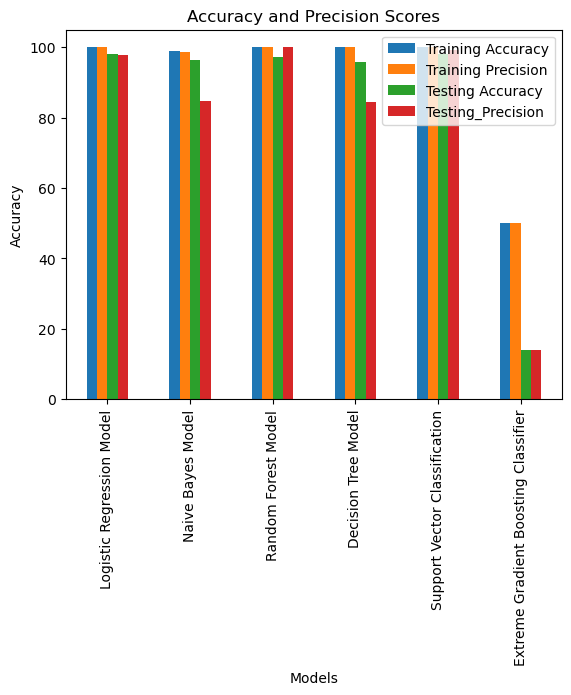

In [62]:
scores_dataframes.plot(kind = "bar", title = "Accuracy and Precision Scores", xlabel = "Models", ylabel = "Accuracy")

In [63]:
confusion_matrix_LogisticRegressionModel = confusion_matrix(Y_test, Y_pred_test_LogisticRegressionModel)
confusion_matrix_NaiveBayesModel = confusion_matrix(Y_test, Y_pred_test_NaiveBayesModel)
confusion_matrix_RandomForestModel = confusion_matrix(Y_test, Y_pred_test_RandomForestModel)
confusion_matrix_DecisionTreeModel = confusion_matrix(Y_test, Y_pred_test_DecisionTreeModel)
confusion_matrix_SupportVectorClassification = confusion_matrix(Y_test, Y_pred_test_SupportVectorClassification)
confusion_matrix_ExtremeGradientBoostingClassifier = confusion_matrix(Y_test, Y_pred_test_ExtremeGradientBoostingClassifier)

Text(0.5, 1.0, 'XGBoost')

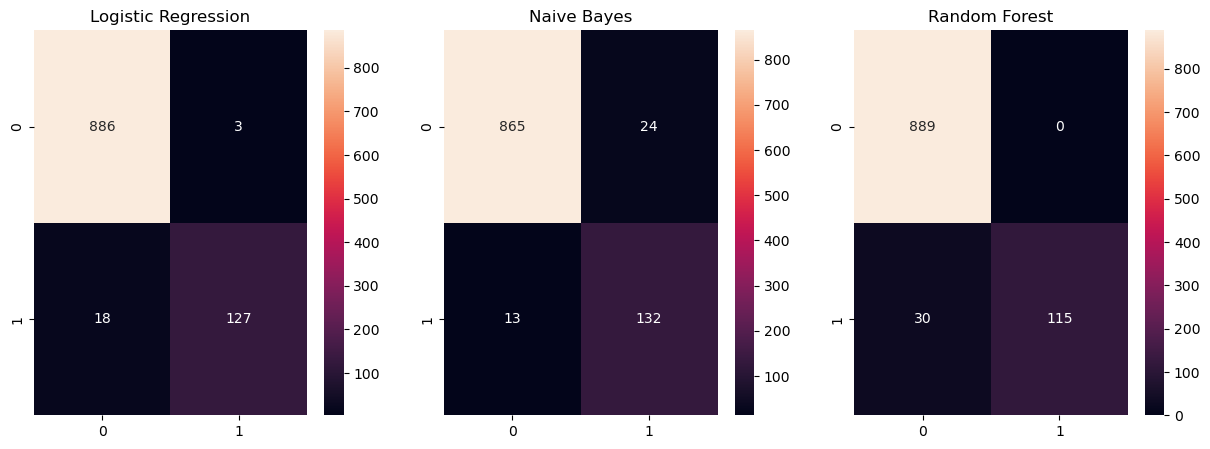

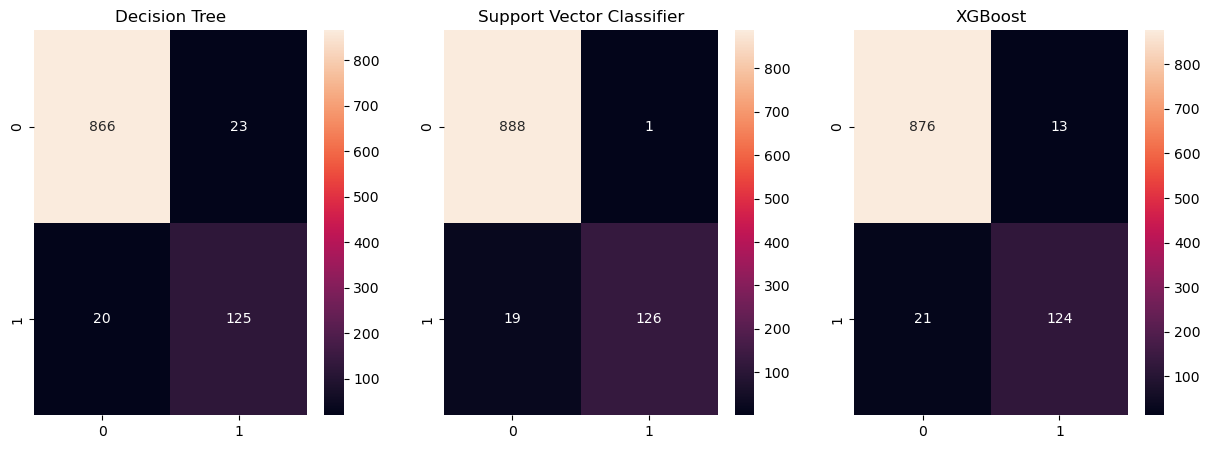

In [64]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix_LogisticRegressionModel, annot = True, fmt = "d")
plt.title("Logistic Regression")

plt.subplot(1,3,2)
sns.heatmap(confusion_matrix_NaiveBayesModel, annot = True, fmt = "d")
plt.title("Naive Bayes")

plt.subplot(1,3,3)
sns.heatmap(confusion_matrix_RandomForestModel, annot = True, fmt = "d")
plt.title("Random Forest")

plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix_DecisionTreeModel, annot = True, fmt = "d")
plt.title("Decision Tree")

plt.subplot(1,3,2)
sns.heatmap(confusion_matrix_SupportVectorClassification, annot = True, fmt = "d")
plt.title("Support Vector Classifier")

plt.subplot(1,3,3)
sns.heatmap(confusion_matrix_ExtremeGradientBoostingClassifier, annot = True, fmt = "d")
plt.title("XGBoost")

# Test 

In [67]:
input1 =''' Hi, I am a student of Charusat University. I am writing this mail to inform you that I have been selected for the internship at Google. I am very excited to work with you.'''
input = clean_text(input1)
print(input)
input = vectorizer.transform([input])
print(Label_Encoder.inverse_transform(LogisticRegressionModel.predict(input)))

student charusat university writing mail inform selected internship google excited work
['ham']
